# 인공지능 정보보안 과제
- kdd99_train.csv 을 이용하여 분류기를 학습시키고,   
kdd99_test.csv 을 이용하여 분류기의 최종 성능을 보고하시오. 

## 목차
1. 데이터 로드
2. 데이터 전처리
    1) 분산이 적은 데이터 삭제
    2) 상관관계가 적은 데이터 삭제
3. 모델학습
4. 모델평가
5. 결론


In [1]:
!source ./myenv/bin/activate


## 1. 데이터 로드

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time

test_path=os.path.join("data", "kdd99_test.csv")
train_path=os.path.join("data", "kdd99_train.csv")

test_data=pd.read_csv(test_path)
train_data=pd.read_csv(train_path)

### 질문? 중복데이터가 많다고 다 지워야 할까?

- 지워야한다
    - 중복된 데이터로 계속해서 학습 할 시에는 과대 적합이 일어날 확률이 더욱 높아진다
    - 해킹을 인식해야하기 때문에 중복의 데이터는 유의미 하지 않을 수 있다.
- 지우지 말아야한다
    - Ddos 공격같은 경우에는 동일한 데이터가 무차별 적으로 들어온다.(그렇다면 이러한 패턴도 배우게 하면 좋지않을까?)
    - 중복된 양을 모두 지우면 기존의 통계적 특징이 줄어들 가능성이 있다.

##### 결론 : ddos와 같이 지속된 공격의 시계열 특징을 배우게 할 수 있다면 지우지 말고 시계열의 특징을 학습 할 수 없다면 제거하자.

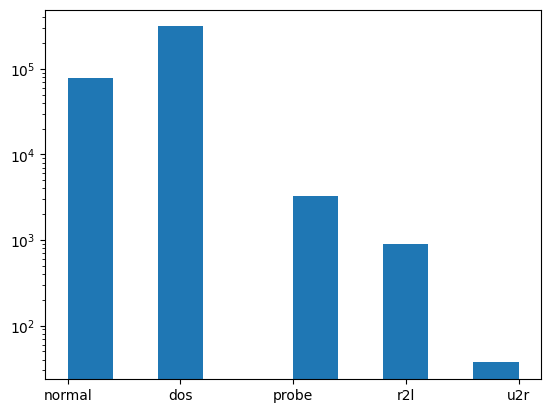

In [3]:
train_data.duplicated().sum() # 275,042의 중복 데이터가 많다.

plt.hist(train_data["Attack Type"])
plt.yscale("log")
plt.show()

## 2. 데이터 전처리  
- 유의사항 
    - 1) Variance가 너무 낮은 (상수에 가까운) 변수들 제거
    - 2) Pearson Correlation Coefficient를 이용

In [4]:
# train, test 데이터 분리   
train_x=train_data.drop(columns=["Attack Type"])
train_y=train_data["Attack Type"]
test_x=test_data.drop(columns=["Attack Type"])
test_y=test_data["Attack Type"]

# y데이터 라벨링
attack_condition=['normal', 'dos', 'probe', 'r2l', 'u2r']
label=[0,1,2,3,4]
train_y=train_y.replace(attack_condition,label)
test_y=test_y.replace(attack_condition,label)

# 2개 이하의 unique값을 가지는 column은 제거
train_x=train_x[[col for col in train_x.columns if train_x[col].nunique()>2]] 

#숫자형 데이터의와 문자형 데이터를 나누어 처리하기 위하여 나누어 놓음.
numerical_cols = train_x._get_numeric_data().columns
categorical_cols = list(set(train_x.columns)-set(numerical_cols))

print("각 피처의 분산 정도는?")
for feature in train_x.columns:
    print(f"{feature} : {len(train_x[feature].unique())}")


/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/2777072036.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_y=train_y.replace(attack_condition,label)
/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/2777072036.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_y=test_y.replace(attack_condition,label)


각 피처의 분산 정도는?
duration : 2126
protocol_type : 3
service : 65
flag : 11
src_bytes : 3063
dst_bytes : 9773
wrong_fragment : 3
urgent : 4
hot : 22
num_failed_logins : 6
lnum_compromised : 21
lsu_attempted : 3
lnum_root : 18
lnum_file_creations : 15
lnum_access_files : 6
count : 484
srv_count : 457
serror_rate : 89
srv_serror_rate : 48
rerror_rate : 74
srv_rerror_rate : 49
same_srv_rate : 97
diff_srv_rate : 76
srv_diff_host_rate : 64
dst_host_count : 256
dst_host_srv_count : 256
dst_host_same_srv_rate : 101
dst_host_diff_srv_rate : 101
dst_host_same_src_port_rate : 101
dst_host_srv_diff_host_rate : 63
dst_host_serror_rate : 97
dst_host_srv_serror_rate : 64
dst_host_rerror_rate : 101
dst_host_srv_rerror_rate : 101


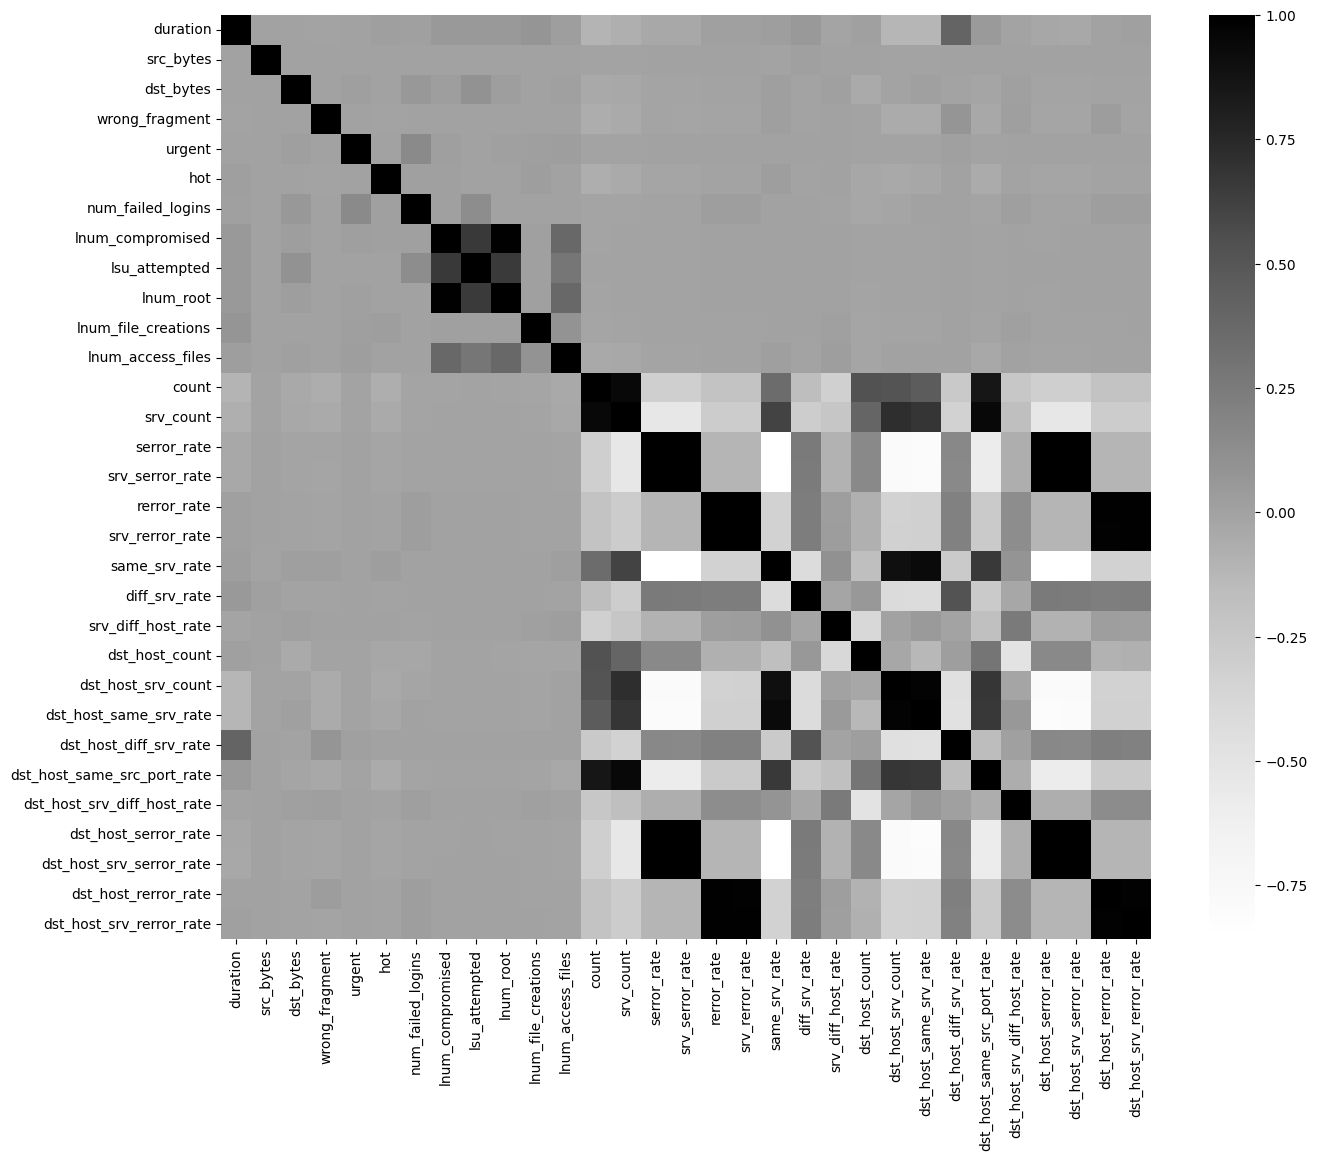

In [5]:
# 상관관계 분석을 위한 히트맵(검은 색 일 수록 상관 관계가 높다)
df=train_x[numerical_cols]
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr,cmap='Greys')
plt.show()

질문? 숫자가 아닌 데이터들을 어떻게 숫자화 할까?

protocol_type 과 같은 데이터는 3개 의 타입밖에 없기 때문에 괜찮을거같은데

임베딩을 하기에는 너무 하고

In [6]:
# 2) 상관관계가 높은 피처 제거
dropped_set=set()
for i in range(len(numerical_cols)-1):
    for j in range(i+1, len(numerical_cols)):
        x1 = numerical_cols[i]
        x2 = numerical_cols[j]
        if x1 in dropped_set:
            continue
        
        if abs(train_x[x1].corr(train_x[x2]))>0.90:
            print(f"Correlation between {x1} and {x2}: {train_x[x1].corr(train_x[x2])}")
            dropped_set.add(x2)
print(dropped_set) 

print("dropped_cols:", len(dropped_set))

train_x=train_x.drop(columns=dropped_set)

numerical_cols = set(numerical_cols) - dropped_set
numerical_cols = list(numerical_cols)

Correlation between lnum_compromised and lnum_root: 0.9919093686068854
Correlation between count and srv_count: 0.9435762641394275
Correlation between serror_rate and srv_serror_rate: 0.9983860738343507
Correlation between serror_rate and dst_host_serror_rate: 0.9987139444989593
Correlation between serror_rate and dst_host_srv_serror_rate: 0.9978601526955325
Correlation between rerror_rate and srv_rerror_rate: 0.9947680801888682
Correlation between rerror_rate and dst_host_rerror_rate: 0.9872237682966359
Correlation between rerror_rate and dst_host_srv_rerror_rate: 0.985630469281604
Correlation between same_srv_rate and dst_host_same_srv_rate: 0.9276943535129264
Correlation between dst_host_srv_count and dst_host_same_srv_rate: 0.9737238312180813
{'dst_host_rerror_rate', 'dst_host_srv_serror_rate', 'srv_count', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_srv_rerror_rate', 'lnum_root', 'dst_host_serror_rate', 'dst_host_same_srv_rate'}
dropped_cols: 9


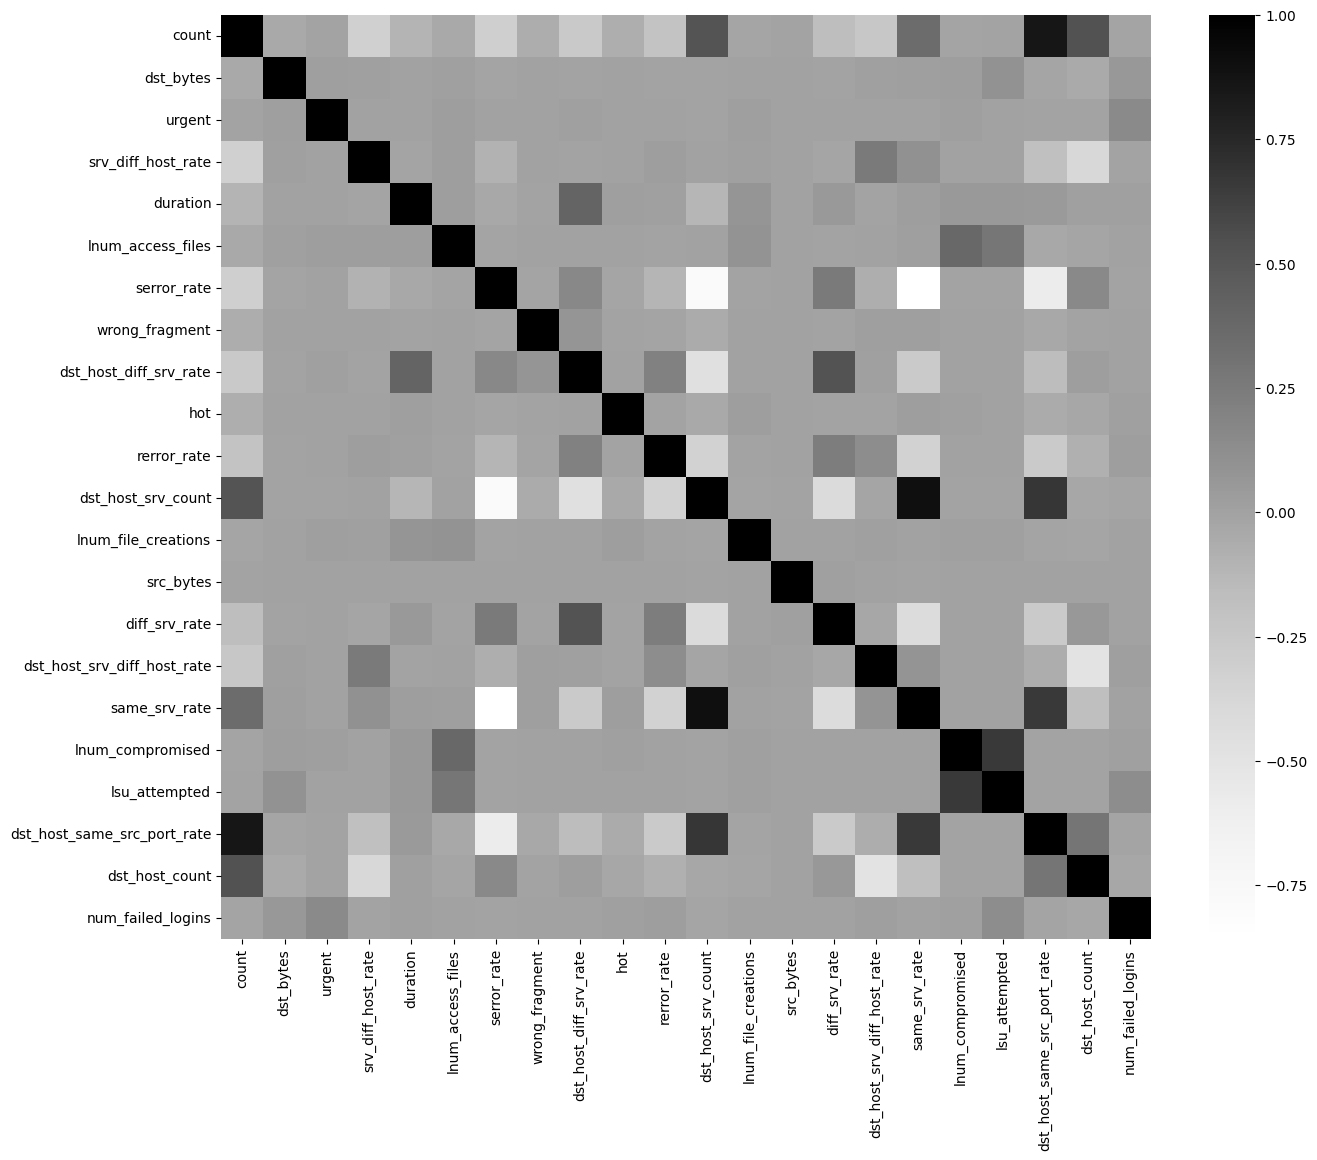

In [7]:
# 재비교 (진한 검은색이 현저히 줄었다)
df=train_x[numerical_cols]
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr,cmap='Greys')
plt.show()

In [8]:
# 숫자가 아닌 데이터들의 숫자화
print(train_x[categorical_cols].describe())
categori_mapping_dict = {}
for col in categorical_cols:
    n=0
    df=train_x[col]
    print(df.unique())
    categori_mapping_dict[col]={}
    for item in df.unique():
        categori_mapping_dict[col][item]=n
        n+=1
    train_x[col]=train_x[col].replace(categori_mapping_dict[col])
    test_x[col]=test_x[col].replace(categori_mapping_dict[col])
test_x["service"].replace('tftp_u',-1,inplace=True)
print(categori_mapping_dict)

          flag service protocol_type
count   395216  395216        395216
unique      11      65             3
top         SF   ecr_i          icmp
freq    302750  224993        226735
['SF' 'S0' 'REJ' 'RSTR' 'S1' 'RSTO' 'SH' 'S2' 'S3' 'RSTOS0' 'OTH']


/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/321568344.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_x[col]=train_x[col].replace(categori_mapping_dict[col])
/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/321568344.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_x[col]=test_x[col].replace(categori_mapping_dict[col])


['http' 'ecr_i' 'private' 'printer' 'ftp' 'smtp' 'urp_i' 'other'
 'ftp_data' 'domain_u' 'klogin' 'domain' 'eco_i' 'uucp_path' 'finger'
 'nnsp' 'systat' 'rje' 'auth' 'netstat' 'gopher' 'mtp' 'link' 'telnet'
 'urh_i' 'imap4' 'ntp_u' 'IRC' 'shell' 'iso_tsap' 'http_443' 'name'
 'supdup' 'pop_3' 'netbios_dgm' 'bgp' 'efs' 'uucp' 'sunrpc' 'ldap'
 'remote_job' 'ctf' 'nntp' 'netbios_ssn' 'ssh' 'echo' 'vmnet' 'sql_net'
 'time' 'Z39_50' 'login' 'whois' 'courier' 'kshell' 'discard' 'hostnames'
 'netbios_ns' 'csnet_ns' 'pop_2' 'exec' 'daytime' 'X11' 'tim_i' 'red_i'
 'pm_dump']
['tcp' 'icmp' 'udp']
{'flag': {'SF': 0, 'S0': 1, 'REJ': 2, 'RSTR': 3, 'S1': 4, 'RSTO': 5, 'SH': 6, 'S2': 7, 'S3': 8, 'RSTOS0': 9, 'OTH': 10}, 'service': {'http': 0, 'ecr_i': 1, 'private': 2, 'printer': 3, 'ftp': 4, 'smtp': 5, 'urp_i': 6, 'other': 7, 'ftp_data': 8, 'domain_u': 9, 'klogin': 10, 'domain': 11, 'eco_i': 12, 'uucp_path': 13, 'finger': 14, 'nnsp': 15, 'systat': 16, 'rje': 17, 'auth': 18, 'netstat': 19, 'gopher': 20,

/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/321568344.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_x["service"].replace('tftp_u',-1,inplace=True)
/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/321568344.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', T

In [9]:
# train, test 데이터의 피처 개수 맞추기
test_x.drop(columns= list(set(test_x.columns)-set(train_x.columns)), inplace=True)

## 3. 모델학습

In [10]:
from sklearn.metrics import recall_score, f1_score


def get_f1_score(y, pred_y):
    return f1_score(y, pred_y, average='macro')

def get_recall(y, pred_y):
    return recall_score(y, pred_y, average='macro')

In [11]:

from sklearn.naive_bayes import GaussianNB

time_list=[]
acc_list=[]
model_name=[]
f1_list=[]
recall_list=[]

model1 = GaussianNB()
print("GaussianNB")

start_time = time.time()
model1.fit(train_x, train_y)
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred1 = model1.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time)

print("Train score is:", model1.score(train_x, train_y))
print("Test score is:",model1.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model1.score(test_x,test_y))
model_name.append("GaussianNB")

f1=get_f1_score(test_y, Y_test_pred1)
print("F1 score is:", f1)
f1_list.append(f1)

recall=get_recall(test_y, Y_test_pred1)
print("Recall is:", recall)
recall_list.append(recall)


GaussianNB
Training time:  0.11210989952087402
Testing time:  0.04372406005859375
Train score is: 0.8900221650945306
Test score is: 0.8897919112586535
F1 score is: 0.3440516815961403
Recall is: 0.4602815694422041


In [12]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
print("DecisionTree")

start_time = time.time()
model2.fit(train_x, train_y.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred2 = model2.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time)

print("Train score is:", model2.score(train_x, train_y))
print("Test score is:",model2.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model2.score(test_x,test_y))
model_name.append("DecisionTree")

f1=get_f1_score(test_y, Y_test_pred2)
print("F1 score is:", f1)
f1_list.append(f1)

recall=get_recall(test_y, Y_test_pred2)
print("Recall is:", recall)
recall_list.append(recall)


DecisionTree
Training time:  0.5255541801452637
Testing time:  0.010480880737304688
Train score is: 0.9999316829278166
Test score is: 0.9996154001862273
F1 score is: 0.9446285908082673
Recall is: 0.9411556181054659


In [13]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(n_estimators=30)
print("RandomForest")

start_time = time.time()
model3.fit(train_x, train_y.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred3 = model3.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time)

print("Train score is:", model3.score(train_x, train_y))
print("Test score is:",model3.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model3.score(test_x,test_y))
model_name.append("RandomForest")

f1 = get_f1_score(test_y, Y_test_pred3)
print("F1 score is:", f1)
f1_list.append(f1)

recall=get_recall(test_y, Y_test_pred3)
print("Recall is:", recall)
recall_list.append(recall)




RandomForest
Training time:  4.476383924484253
Testing time:  0.12119793891906738
Train score is: 0.9999949394761346
Test score is: 0.9996255212339581
F1 score is: 0.9350302154985387
Recall is: 0.9073039809666918


In [14]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
print("XGB")

start_time = time.time()
model.fit(train_x, train_y.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred4 = model.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time) 

print("Train score is:", model.score(train_x, train_y))
print("Test score is:",model.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model.score(test_x,test_y))
model_name.append("XGB")

f1 = get_f1_score(test_y, Y_test_pred4)
print("F1 score is:", f1)
f1_list.append(f1)  

recall=get_recall(test_y, Y_test_pred4)
print("Recall is:", recall)
recall_list.append(recall)


XGB


/Users/bagminjun/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:14:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time:  6.112810373306274
Testing time:  0.08058810234069824
Train score is: 1.0
Test score is: 0.9998380632363062
F1 score is: 0.9471938133963889
Recall is: 0.9169311050339294


## 5. 결론

/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/3391883598.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_name, rotation=45)
/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/3391883598.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_name, rotation=45)
/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/3391883598.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_name, rotation=45)
/var/folders/41/m943kfs10r907z5fmg030_6w0000gn/T/ipykernel_39852/3391883598.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabe

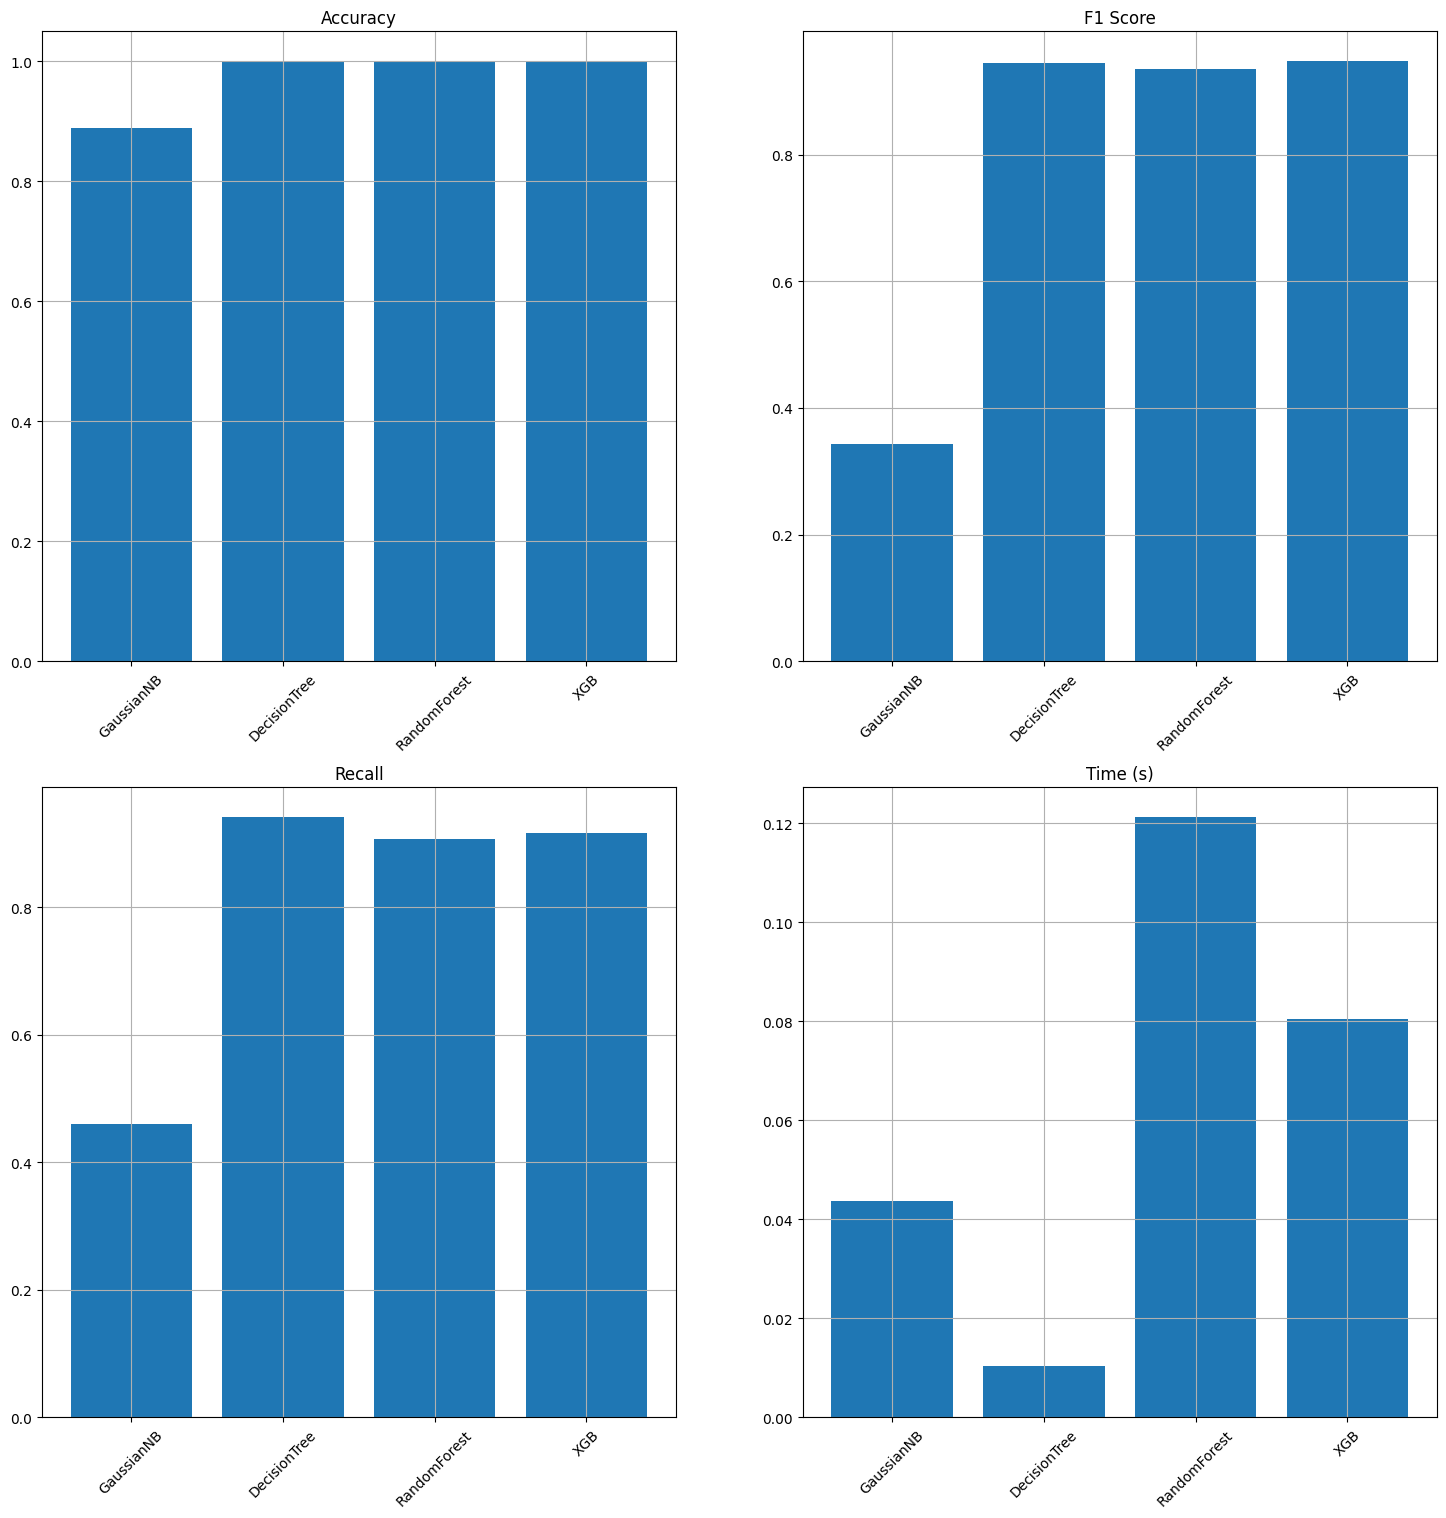

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))

axs[0, 0].bar(model_name, acc_list)
axs[0, 0].set_title('Accuracy')

axs[0, 1].bar(model_name, f1_list)
axs[0, 1].set_title('F1 Score')

axs[1, 0].bar(model_name, recall_list)
axs[1, 0].set_title('Recall')

axs[1, 1].bar(model_name, time_list)
axs[1, 1].set_title('Time (s)')

for ax in axs.flat:
    ax.grid(True)
    ax.set_xticklabels(model_name, rotation=45)

plt.show()

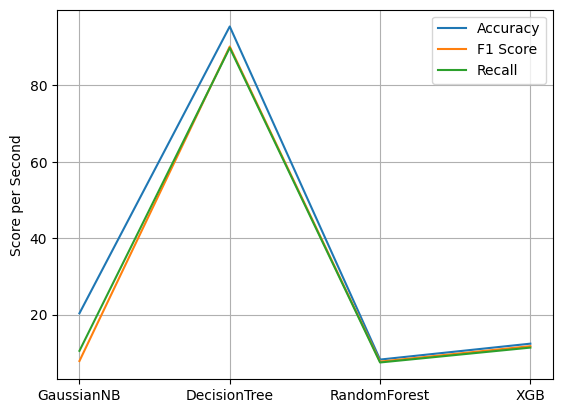

In [16]:
acc_list=np.array(acc_list)
time_list=np.array(time_list)
f1_list=np.array(f1_list)
recall_list=np.array(recall_list)

plt.plot(model_name, acc_list/time_list, label='Accuracy')
plt.plot(model_name, f1_list/time_list, label='F1 Score')
plt.plot(model_name, recall_list/time_list, label='Recall')
plt.ylabel('Score per Second')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim

# PyTorch Tensor 변환
X_train = torch.FloatTensor(train_x.values)
X_test = torch.FloatTensor(test_x.values)
y_train = torch.FloatTensor(train_y).reshape(-1, 1)
y_test = torch.FloatTensor(test_y).reshape(-1, 1)

# 2. ANN 모델 정의
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 6)  # 입력층 → 은닉층
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(6, 1)           # 은닉층 → 출력층
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# 모델 인스턴스 생성
model = ANN(input_size=X_train.shape[1])

# 손실함수와 옵티마이저 정의
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)




  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 22.7 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.4/808.4 kB 20.4 MB/s  0:00:00
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [torchaudio]8 [torchaudio]]


In [ ]:
# 3. 모델 학습
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_cls = y_pred.round()
    acc = (y_pred_cls.eq(y_test).sum() / float(y_test.shape[0])).item()
    print(f'Accuracy: {acc:.4f}')